In [1]:
from fmp_python.fmp import FMP
import pandas as pd
from dotenv import load_dotenv
import os
import numpy as np
import statsmodels.api as sm
import sklearn as sk

load_dotenv()
FMP_API_KEY = os.getenv("FMP_API_KEY")
fmp = FMP(output_format='pandas',api_key=FMP_API_KEY)

## Module 1 - Visualizing and Munging Stock Data

In [2]:
ms = fmp.get_historical_price("MSFT")
fb = fmp.get_historical_price("META")

ms['date'] = pd.to_datetime(ms['date'],yearfirst=True)
fb['date'] = pd.to_datetime(fb['date'],yearfirst=True)

ms = ms.set_index('date')
fb = fb.set_index('date')

fb = fb.sort_index()
ms = ms.sort_index()

In [3]:
fb['price_diff'] = fb['close'].shift(-1) - fb['close'] #shift(-1)

In [4]:
fb['daily_return'] = fb['price_diff'] / fb['close']

In [5]:
fb['direction'] = 0
fb.loc[fb['price_diff']>0,'direction'] = 1
fb.loc[fb['price_diff']<=0,'direction'] = -1

In [6]:
fb['rolling_10'] = fb['close'].rolling(window='10D').mean() #fast signal
fb['rolling_20'] = fb['close'].rolling(window='20D').mean() #previous practice
fb['rolling_50'] = fb['close'].rolling(window='50D').mean() #slow signla

<Axes: xlabel='date'>

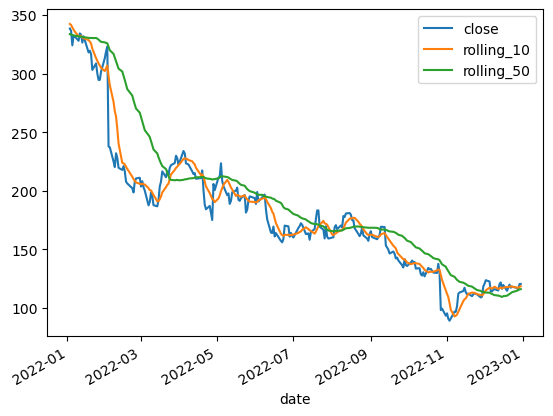

In [7]:
fb_2022 = fb.iloc[fb.index.year == 2022]

fb_2022[['close','rolling_10','rolling_50']].plot()

<Axes: xlabel='date'>

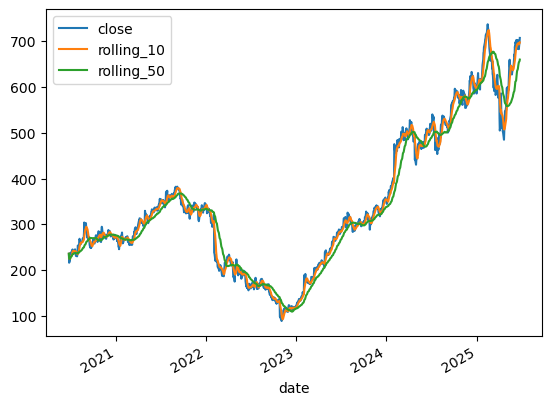

In [8]:
fb[['close','rolling_10','rolling_50']].plot()

In [9]:
#Trading Strategy:
#If rolling_10 > rolling_50 -> buy and hold (long)

fb['shares'] = [1 if fb.loc[ei,'rolling_10']>fb.loc[ei,'rolling_50'] else 0 for ei in fb.index]

In [10]:
fb['profit'] = [fb.shift(-1).loc[ei,'close']-fb.loc[ei,'close'] if fb.loc[ei,'shares'] else 0 for ei in fb.index]

In [11]:
fb['wealth'] = fb['profit'].cumsum()

In [12]:
fb.loc[fb['wealth']< 0] #All spots where wealth was negative

,open,high,low,close,adjClose,volume,unadjustedVolume,change,changePercent,vwap,...,changeOverTime,price_diff,daily_return,direction,rolling_10,rolling_20,rolling_50,shares,profit,wealth
date,,,,,,,,,,,,,,,,,,,,,
2020-07-10,243.69,245.49,239.32,245.07,243.73,22982716,22982716,1.38,0.56629,243.3925,...,0.005663,-6.07,-0.024768,-1,240.751429,234.975455,234.975455,1,-6.07,-1.28
2020-07-13,247.01,250.15,238.42,239.00,237.70,24674900,24674900,-8.00,-3.24000,243.6450,...,-0.032400,0.73,0.003054,1,242.215000,235.310833,235.310833,1,0.73,-0.55
2020-07-21,246.22,246.91,240.08,241.75,240.43,19409687,19409687,-4.47,-1.82000,243.7400,...,-0.018200,-1.88,-0.007777,-1,241.305714,241.296154,237.437222,1,-1.88,-0.41
2020-07-22,240.26,241.90,238.12,239.87,238.56,15427900,15427900,-0.39,-0.16232,240.0375,...,-0.001623,-7.27,-0.030308,-1,241.126250,241.792308,237.565263,1,-7.27,-7.68
2020-07-23,239.63,242.42,231.75,232.60,231.33,21771802,21771802,-7.03,-2.93000,236.6000,...,-0.029300,-1.89,-0.008126,-1,240.326250,241.135714,237.317000,1,-1.89,-9.57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-25,141.22,143.17,140.31,141.50,140.73,26622021,26622021,0.28,0.19827,141.5500,...,0.001983,5.80,0.040989,1,138.830000,136.220769,125.657576,1,5.80,-9.29
2023-01-26,144.40,147.51,143.30,147.30,146.50,25482100,25482100,2.90,2.01000,145.6275,...,0.020100,4.44,0.030143,1,139.888750,137.550000,126.668788,1,4.44,-4.85
2023-01-27,148.24,153.19,147.39,151.74,150.91,35771900,35771900,3.50,2.36000,150.1400,...,0.023600,-4.68,-0.030842,-1,141.936250,138.563571,127.772121,1,-4.68,-9.53


## Module 2 - Random Variables & Distributions

At the end of the previous module our *wealth* went below 0.
We'd like to avoid this as it's related to "bankruptcy", we need to compute the probability of such losses to decide if we have the 'appetite' for such risk occuring

In [13]:
die = pd.DataFrame([1,2,3,4,5,6]) # A six sided dice can implement in pandas as a dataFrame with 6 values (1 through 6)

#.sample() takes from a data frame and returns a new dataFrame with 'randomly' selected entires. replace=True is a parameter that allows for repeaters

trial_1 = die.sample(2,replace=True) # This trial_1 is the result of rolling two independent 6-sided dice, it'll change each time it's ran

We can simulate multiple rolls of two dice by re-running the same code. If we're interested in the sum we can use the Dataframe method *.sum()* and even record the results in an array

In [14]:
trial = 5000
trial_data = pd.DataFrame([die.sample(2,replace=True).sum()[0] for _ in range(trial)]) # now we have 50 'simulated' two dice rolls

In [15]:
# the [0] gives the first column (exclusing index) from the dataFrame
#.value_counts() returns a series with index being the unique values found and the first column being the total count of that index

frequencies = trial_data[0].value_counts()

<Axes: xlabel='0'>

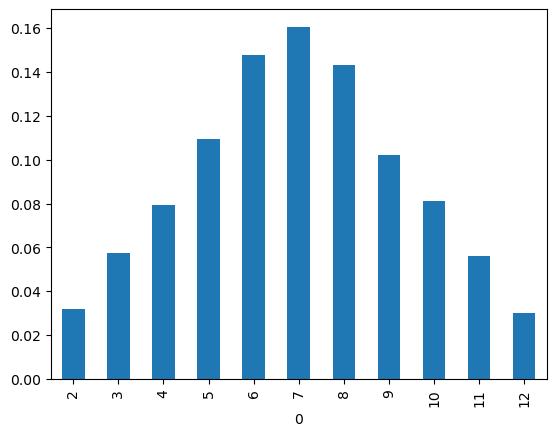

In [16]:
sorted_frequencies = frequencies.sort_index() / trial
sorted_frequencies.plot(kind='bar')

In [17]:
mean_value = (sorted_frequencies.index * sorted_frequencies).sum()

In [18]:
variance = (((sorted_frequencies.index - mean_value) ** 2) * sorted_frequencies).sum()

In [19]:
print(mean_value, variance)

6.9722 5.95622716


In [20]:
ap = fmp.get_historical_price("AAPL")
ap['date'] = pd.to_datetime(ap['date'],yearfirst=True)
ap = ap.set_index('date')
ap = ap.sort_index()

In [21]:
ap['log_return'] = np.log(ap['close']/ap['close'].shift(1))
ap['simple_return'] = ap['close'].pct_change()

<Axes: ylabel='Frequency'>

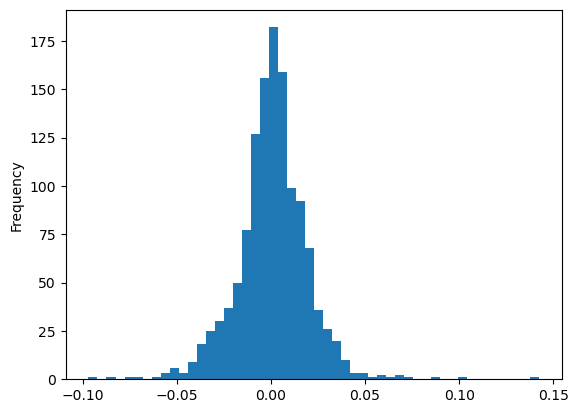

In [22]:
ap['log_return'].plot(kind='hist',bins=50)

In [23]:
from scipy.stats import norm

In [24]:
density = pd.DataFrame()

density['x'] = np.arange(-4,4,0.001)
density['pdf'] = norm.pdf(density['x'])
density['cdf'] = norm.cdf(density['x'])

#Default for norm is loc=0, scale=1, i.e., mean = 0 and std dev = 1

<Axes: xlabel='x'>

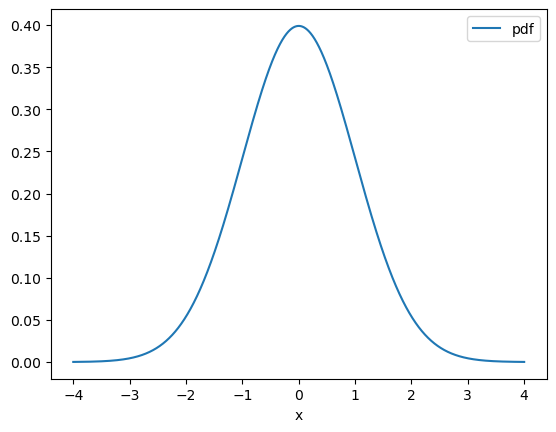

In [25]:
density.plot(x='x',y='pdf')

In [26]:
mu = ap['log_return'].mean()
sigma = ap['log_return'].std()

In [27]:
density_ap = pd.DataFrame()

density_ap['x'] = np.arange(ap['log_return'].min(),ap['log_return'].max(),0.001)
density_ap['pdf'] = norm.pdf(density_ap['x'],loc=mu,scale=sigma)
density_ap['cdf'] = norm.cdf(density_ap['x'],loc=mu,scale=sigma)

<Axes: xlabel='x'>

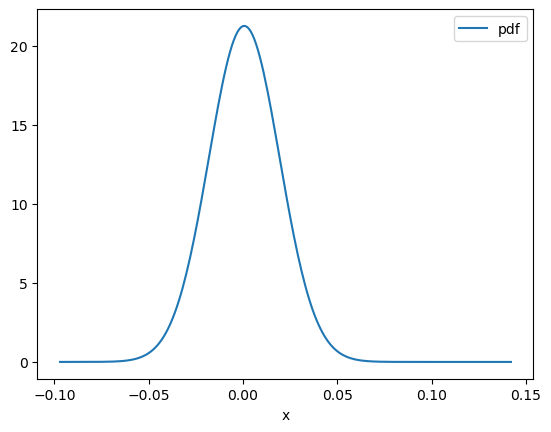

In [28]:
density_ap.plot(x='x',y='pdf')

In [29]:
# norm.expect() calculates the expected value between lb (lower bound) and ub (uppper bound)
# if the function is f(x) = 1, then this corresponds to the area under the distribution
# which is the probability of observing an event between the bounds
# UPDATE: use cdf with a fixed value (duh)
prob_big_loss = norm.cdf(-0.05, loc=mu, scale=sigma)
print(f"The probability of experiencing a daily log return of less than 5% is {prob_big_loss}")

The probability of experiencing a daily log return of less than 5% is 0.003497704568047516


In [30]:
# We can update to the yearly by appropriate scaling (using 220 trading days in a year)
# This scaling assumes each day is independent, which is generally (and commonly) not true
# Only use a loose estimate or for toy models
mu_year = 220 * mu
sigma_year = np.sqrt(220) * sigma
prob_big_loss_year = norm.cdf(-0.40, loc=mu_year, scale=sigma_year)
print(f"The probability of experiencing a annual log return of less than 40% is {prob_big_loss_year}")


The probability of experiencing a annual log return of less than 40% is 0.026145762757727963


## Value at Risk (VaR)

Measures the % loss of an investment at a given probability

In [31]:
norm.ppf(0.05, loc=mu, scale=sigma) #VaR at 95% --> 5% chance the daily log return is worse than -3%

np.float64(-0.030244341027863886)

# Module 4 - Linear Regression Models for Financial Analysis

In [160]:
import yfinance as yf

In [161]:
PERIOD='5y'
spy_data = yf.Ticker("SPY").history(period=PERIOD)
sp500_data = yf.Ticker("^GSPC").history(period=PERIOD)
nasdaq_data = yf.Ticker("^IXIC").history(period=PERIOD)
cac40_data = yf.Ticker("^FCHI").history(period=PERIOD)
dax_data = yf.Ticker("^GDAXI").history(period=PERIOD)
aord_data = yf.Ticker("^AORD").history(period=PERIOD)
hsi_data = yf.Ticker("^HSI").history(period=PERIOD)
nikkei_data = yf.Ticker("^N225").history(period=PERIOD)

In [162]:
def strip_timezone(df):
    local_df = df.copy()
    local_df.index = local_df.index.tz_localize(None).normalize()
    return local_df

In [163]:
def predictor_value(df,name,isAsian):
    local_df = df.copy()
    if isAsian == 2:
        predictor_df = (local_df['Close']-local_df['Open'])/local_df['Open']
        return pd.DataFrame(data=predictor_df.to_numpy(),index=predictor_df.index,columns=[name])
    else:
        predictor_df = local_df['Open'].pct_change()
        return pd.DataFrame(data=predictor_df.to_numpy(),index=predictor_df.index,columns=[name])

In [164]:
predictor_data = [strip_timezone(i) for i in [spy_data, sp500_data, nasdaq_data, cac40_data, dax_data, aord_data, hsi_data, nikkei_data]]
predictor_region = [0, 0, 0, 1, 1, 1, 2, 2]
predictor_name = ['spy','sp500','nasdaq','cac40','dax','aord','hsi','nikkei']


response_data = predictor_data[0]
processed_data = pd.DataFrame((response_data['Open'].pct_change().shift(-1)).to_numpy(),index=response_data.index,columns=['response'])

In [165]:
for i in range(len(predictor_data)):
    current_data = predictor_data[i].copy()
    current_name = predictor_name[i]
    current_region = predictor_region[i]

    new_data = predictor_value(current_data,current_name,current_region)
    processed_data = processed_data.merge(new_data,how='left',on='Date')

In [166]:
date_sets = [set(x.index) for x in predictor_data]

In [167]:
for i in range(len(date_sets)):
    print(f"{predictor_name[i].upper()} missed {len(date_sets[0].difference(date_sets[i]))} dayes present in the SPY")

SPY missed 0 dayes present in the SPY
SP500 missed 0 dayes present in the SPY
NASDAQ missed 0 dayes present in the SPY
CAC40 missed 10 dayes present in the SPY
DAX missed 16 dayes present in the SPY
AORD missed 27 dayes present in the SPY
HSI missed 63 dayes present in the SPY
NIKKEI missed 77 dayes present in the SPY


In [168]:
#Remove the nan values associated with alignment issues from pct_change calculation
processed_data.drop([processed_data.index[0],processed_data.index[-1]],axis=0,inplace=True)
#For missed days, input 0 to indicate no change
processed_data.fillna(0,inplace=True)

In [169]:
# correlations between the response and the various indexs
processed_data.corr()['response']

response    1.000000
spy        -0.106744
sp500      -0.091090
nasdaq     -0.068689
cac40      -0.104402
dax        -0.135990
aord        0.104073
hsi        -0.035244
nikkei     -0.060320
Name: response, dtype: float64

### Interpretations

- The US markets are highly correlated with each other. Fairly correlated with EU markets and weakly correlated with Asian markets

- <code>.corr()</code> suggests that the *'strongest'* correlation is with the DAX & CAC40. Visually they are fairly clustered.

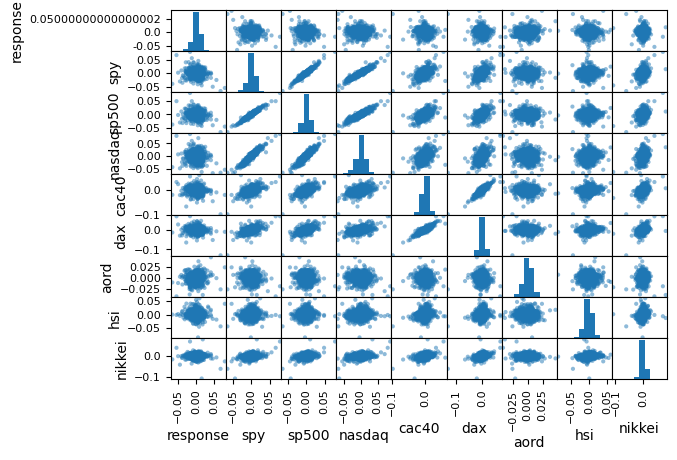

In [170]:
_ = pd.plotting.scatter_matrix(processed_data)

In [171]:
X = processed_data.drop(columns=['response'])
y = processed_data['response']
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X,y,test_size=0.2,random_state=42)

In [172]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train_binary = (np.sign(y_train) + 1)/2
y_test_binary = (np.sign(y_test) + 1)/2

model_log = sm.Logit(y_train_binary,X_train_scaled)
result_log = model_log.fit()

model_ols = sm.OLS(y_train,X_train)
result_ols = model_ols.fit()

Optimization terminated successfully.
         Current function value: 0.684486
         Iterations 4


In [173]:
result_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               response   R-squared (uncentered):                   0.049
Model:                            OLS   Adj. R-squared (uncentered):              0.042
Method:                 Least Squares   F-statistic:                              6.460
Date:                Tue, 24 Jun 2025   Prob (F-statistic):                    3.22e-08
Time:                        13:25:03   Log-Likelihood:                          3102.0
No. Observations:                1003   AIC:                                     -6188.
Df Residuals:                     995   BIC:                                     -6149.
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
spy           -0.5861      0.152     -3.854      0.000      -0.885      -0.288
sp500          0.3222      0.156      2.059      0.040       0.015       0.629
nasdaq         0.2251      0.073      3.085      0.002       0.082       0.368
cac40          0.0694      0.073      0.956      0.339      -0.073       0.212
dax           -0.1830      0.068     -2.694      0.007      -0.316      -0.050
aord           0.1385      0.043      3.207      0.001       0.054       0.223
hsi            0.0133      0.030      0.438      0.661      -0.046       0.073
nikkei        -0.0254      0.047     -0.541      0.589      -0.118       0.067
==============================================================================
Omnibus:                      118.744   Durbin-Watson:                   1.890
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              986.624
Skew:                          -0.149   Prob(JB):                    5.72e-215
Kurtosis:                       7.850   Cond. No.                         14.2
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [174]:
result_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               response   No. Observations:                 1003
Model:                          Logit   Df Residuals:                      995
Method:                           MLE   Df Model:                            7
Date:                Tue, 24 Jun 2025   Pseudo R-squ.:                0.004613
Time:                        13:25:06   Log-Likelihood:                -686.54
converged:                       True   LL-Null:                       -689.72
Covariance Type:            nonrobust   LLR p-value:                    0.4981
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.5561      0.323     -1.724      0.085      -1.188       0.076
x2             0.2177      0.307      0.710      0.478      -0.383       0.818
x3             0.4465      0.204      2.190      0.029       0.047       0.846
x4            -0.0052      0.146     -0.036      0.971      -0.291       0.281
x5            -0.0894      0.147     -0.607      0.544      -0.378       0.199
x6             0.1842      0.066      2.785      0.005       0.055       0.314
x7            -0.0391      0.067     -0.580      0.562      -0.171       0.093
x8            -0.0343      0.073     -0.469      0.639      -0.178       0.109
==============================================================================
"""

In [175]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, mean_absolute_error, mean_squared_error, r2_score

In [176]:
y_pred = result_log.get_prediction(X_test_scaled).predicted > 0.5
accuracy = accuracy_score(y_test_binary,y_pred)
precision = precision_score(y_test_binary,y_pred)
recall = recall_score(y_test_binary,y_pred)
f1 = f1_score(y_test_binary,y_pred)
cm = confusion_matrix(y_test_binary, y_pred)
print(f"accuracy = {accuracy}\nprecision = {precision}\nrecall = {recall}\nf1 = {f1}")
print("cm = ",cm)

accuracy = 0.549800796812749
precision = 0.5714285714285714
recall = 0.6268656716417911
f1 = 0.597864768683274
cm =  [[54 63]
 [50 84]]


In [177]:
y_pred_ols = result_ols.get_prediction(X_test_scaled).predicted_mean
mae = mean_absolute_error(y_test,y_pred_ols)
mse = mean_squared_error(y_test,y_pred_ols)
r2 = r2_score(y_test,y_pred_ols)
print(f"Mean Absolute Error = {mae}\nMean Squared Error = {mse}\nR^2 = {r2}")

Mean Absolute Error = 0.1799026321887103
Mean Squared Error = 0.059897525612686825
R^2 = -447.6161442010061


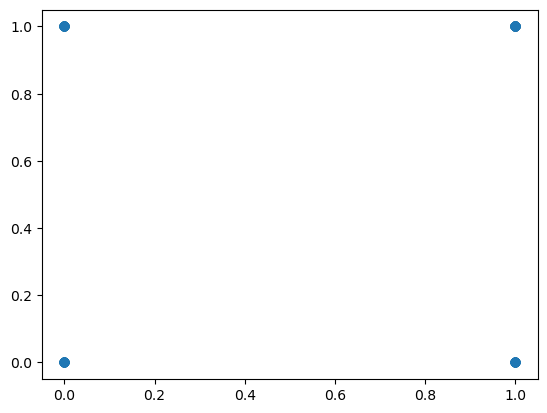